<a href="https://colab.research.google.com/github/AburizalAN/learn-ml/blob/master/nlp/08_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q fastbook
from fastbook import *

In [ ]:
!pip install bertviz

**Disclaimer**: today's lecture is HARD, we tried to make it as simple as possible, but it's still hard 🙏

# Problem With RNN

Before we go on to learn about attention, let's first understand the problem with RNNs.

## Recurrence can't be parallelized

RNNs are sequential models. They process the input one token at a time. This means that the next token can only be processed after the previous token has been processed. This makes it difficult to parallelize the training of RNNs.

Consider the following recurrent function:


In [ ]:
def count_length(words: list) -> int:
    if len(words) == 0:
        return 0
    return len(words[0]) + count_length(words[1:])

count_length(['I', 'am', 'a', 'student'])


11

To calculate `count_length(['I', 'am', 'a', 'student'])` we need to:

1. Calculate `len('I') + count_length(['am', 'a', 'student'])`
1. Calculate `len('I') + len('am') + count_length(['a', 'student'])`
1. Calculate `len('I') + len('am') + len('a') + count_length(['student'])`
1. Calculate `len('I') + len('am') + len('a') + len('student') + count_length([])`
1. Return `len('I') + len('am') + len('a') + len('student') + 0`
1. Return `1 + 2 + 1 + 7 + 0`
1. Return `11`


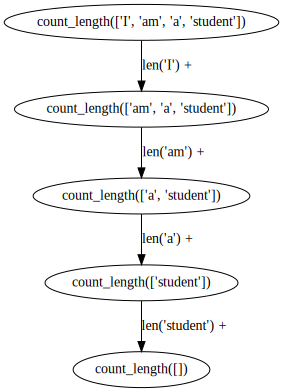

In [ ]:
gv('''
    rankdir="TB";
    a [label="count_length(['I', 'am', 'a', 'student'])"]
    b [label="count_length(['am', 'a', 'student'])"]
    c [label="count_length(['a', 'student'])"]
    d [label="count_length(['student'])"]
    e [label="count_length([])"]
    a -> b [label="len('I') + "]
    b -> c [label="len('am') + "]
    c -> d [label="len('a') + "]
    d -> e [label="len('student') + "]
   ''')

We need to compute them sequentially, one after the other.

Compare it to this function:

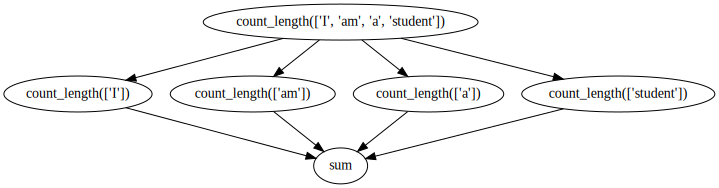

In [ ]:
gv('''
    rankdir="TB";
    a [label="count_length(['I', 'am', 'a', 'student'])"]
    b [label="count_length(['I'])"]
    c [label="count_length(['am'])"]
    d [label="count_length(['a'])"]
    e [label="count_length(['student'])"]
    a -> b
    a -> c
    a -> d
    a -> e
    b -> sum
    c -> sum
    d -> sum
    e -> sum
   ''')

The second function can run in parallel. We can calculate `len('I')`, `len('am')`, `len('a')`, and `len('student')` at the same time. We can then add them up and return the result.

Let's take a look at RNN diagram:

![RNN](https://storage.googleapis.com/rg-ai-bootcamp/nlp/image-24.png)

Does it ressemble the first function or the second? The answer is the first.

The output of the RNN at time step $t$ is dependent on the output of the RNN at time step $t-1$. This means that we can't calculate the output of the RNN at time step $t$ until we have calculated the output of the RNN at time step $t-1$.

## Vanishing Gradient and Exploding Gradient

Another problem with RNN is that it suffers from vanishing gradient. This is because the gradient is multiplied by the same weight matrix at each time step. If the weight matrix is small, the gradient will vanish. If the weight matrix is large, the gradient will explode. This problem, in effect, will have the effect of the model "forgetting" the first few words in the input sequence.

So if we have sentence like below:

> Do not eat that cake because it is poisonous and you will die if you eat that cake, so remember to be careful.

If we have a model that suffers from vanishing gradient, the important part such as "Do not" might be forgotten by the model, end up with "eat that cake" as the output.

Another effect of vanishing gradient is that the model will have a hard time to learn long term dependency, making training the model to take longer time.

## CNN

Remember CNN architecture we learned earlier?

![CNN](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

Compare it with RNN architecture. What do you notice?

CNN can be parallelized! We can calculate the function on different pixel at the same time!

Can we take this idea and apply it to RNN?

# Attention is all you need

We'll learn about transformer, a model that made a breakthrough in the field of NLP, that we've been using in several lectures back. This model first introduced in the paper [Attention is all you need](https://arxiv.org/abs/1706.03762) in 2017. The name of the paper seems like a clickbait at first, but there are two reasons why this paper is named like that:

1. The model use a concept called attention, really heavily
2. The model doesn't use any recurrent or convolutional layers, only attention, so, like the paper said, attention is all you need

Attention is a concept that has been around for a long time, even  has it's usage in RNN. It's basically a way to weight a part of the input sequence, so that the model can focus on that part of the input sequence.

![](https://eleks.com/wp-content/uploads/neural-machine-translation-with-attention-mechanism.gif)

> Image source: https://eleks.com/research/neural-machine-translation-attention-mechanism/

In RNN, the concept of attention is rely on a decoder only focused on a part of the input sequence when want to output in a single time step. What does it mean is that some of the context will have more influence on the output than the others. For example when we want to continue below sentence:

> I went to the __

The concept of attention will make the model to focus on certain words on the input sequence that will influence the output more than the others. For example, if the model focus on the blank space above, the attention will make the model to focus on the word "went" and "to" more than the word "I".

This is because the word "I" doesn't really influence the output, as if we see that input, we can see that we need more words related to a place rather to a person to solve the next word. So making sure that the model focus on the word "went" and "to" will make the model to output a word related to a place, rather than a person.

This concept of attention is done in RNN with one of the reason being to solve the problem of vanishing gradient. By making the model to focus only on certain part of the input sequence, the model will not have to learn the whole input sequence, thus making the model to learn faster, and what's being put into the hidden state will be more effective.

Let's use the following sentence as an example:

> "Father's passport was stolen, so he went to the police station to get a new one."

What we want:
- "he" to have a high attention weight to "Father"
- "passport" to have a high attention weight to "stolen"
- "new one" to have a high attention weight to "passport"
- "went" to have a high attention weight to "police station"

How do we do that?

## Basic Attention Mechanism

We have learned about embedding before. And we also learned that if two tokens are related, they will have similar embedding.

Can we use this to calculate the attention weight? Let's try

In [ ]:
#@title Download and load the word embedding
import os
import numpy as np
import requests, zipfile, io

def download_and_unzip_embeddings(url, directory):
    print(f'Downloading and unzipping embeddings...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=directory)

def load_glove_embeddings(path, url):
    # If file doesn't exist, download and unzip it
    if not os.path.isfile(path):
        download_and_unzip_embeddings(url, path.rsplit('/', 1)[0])

    with open(path, 'r') as f:
        embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
        return embeddings

# URL of GloVe embeddings and the path - replace with your actual URL
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
path = 'glove.6B/glove.6B.300d.txt'

embeddings = load_glove_embeddings(path, url)

from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def load_glove_model(glove_input_file):
    glove_model = KeyedVectors.load_word2vec_format(glove_input_file, binary=False)
    return glove_model

# Convert the GloVe file format to word2vec file format
glove_input_file = 'glove.6B/glove.6B.300d.txt'
word2vec_output_file = 'glove.6B/glove.6B.300d.txt.word2vec'
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file, word2vec_output_file)
model = load_glove_model(word2vec_output_file)

<ipython-input-7-0e38d566b5a0>:47: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Let's print the similarity matrix

In [ ]:
# let's remove stop words and punctuation so that we don't need to deal with them here

sentence = "father passport was stolen so he went to the police station to get a new one"
words = sentence.split(' ')

for i in range(len(words)):
    similarity_score = {}
    for j in range(len(words)):
        if i != j:
            similarity_score[words[j]] = model.similarity(words[i], words[j])
    # print similarity sorted by score take only the top 3
    print(words[i], '=>', sorted(similarity_score.items(), key=lambda kv: kv[1], reverse=True)[:3])

father => [('he', 0.57918006), ('was', 0.41679394), ('went', 0.41016558)]
passport => [('stolen', 0.35170314), ('get', 0.22569309), ('police', 0.22211866)]
was => [('he', 0.6191128), ('the', 0.5451479), ('so', 0.53693634)]
stolen => [('passport', 0.35170314), ('police', 0.32043472), ('he', 0.27722472)]
so => [('get', 0.7669048), ('he', 0.64825845), ('one', 0.6345002)]
he => [('so', 0.64825845), ('was', 0.6191128), ('went', 0.6081544)]
went => [('he', 0.6081544), ('one', 0.49178112), ('so', 0.48603436)]
to => [('to', 1.0), ('get', 0.58743733), ('so', 0.57337403)]
the => [('one', 0.6245334), ('was', 0.5451479), ('so', 0.5447703)]
police => [('one', 0.36144477), ('he', 0.34813938), ('station', 0.34677652)]
station => [('police', 0.34677652), ('one', 0.326971), ('was', 0.32232344)]
to => [('to', 1.0), ('get', 0.58743733), ('so', 0.57337403)]
get => [('so', 0.7669048), ('to', 0.58743733), ('one', 0.5550698)]
a => [('one', 0.60356975), ('the', 0.5241736), ('was', 0.51922)]
new => [('the', 0.

Cool! Do we have the attention weight now?

> "Father's passport was stolen, so he went to the police station to get a new one."

- "passport" is correctly related to "stolen"
- "father" is correctly related to "he"

But what about "new one" and "passport"? They are not related at all!

## Better Attention Mechanism

Before explaining how, let's try to use RoBERTa to calculate the attention weight.



In [ ]:
import torch
from transformers import RobertaTokenizerFast, RobertaModel
import numpy as np
import seaborn as sns

# Load pre-trained model (weights)
# Load pre-trained model (weights)
model = RobertaModel.from_pretrained('deepset/tinyroberta-squad2', output_attentions=True)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = RobertaTokenizerFast.from_pretrained('deepset/tinyroberta-squad2')

def visualize_self_attention_in_context(sentence_A, target_word):
    # Tokenize sentences
    inputs = tokenizer.encode_plus(sentence_A, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids'].to('cpu')

    # Model forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)

    # Attention from all layers and all heads
    attentions_layers = np.array([layer[0, :, :, :].detach().numpy() for layer in outputs.attentions])

    # Mean attention across all heads for each layer
    attentions_heads_mean = attentions_layers.mean(axis=1)

    # Mean attention across all layers
    attentions_all_mean = attentions_heads_mean.mean(axis=0)

    token_list = tokenizer.convert_ids_to_tokens(input_ids[0])
    sep_index = token_list.index('</s>')

    # Focusing on self-attention within sentence_A (offsetting indices for </s> and <s> tags)
    attentions_all_mean_modified = attentions_all_mean[1:sep_index, 1:sep_index]

    # Normalize attention scores for each word
    attentions_all_mean_modified = (attentions_all_mean_modified - attentions_all_mean_modified.min(axis=1, keepdims=True)) / \
                                   (attentions_all_mean_modified.max(axis=1, keepdims=True) - attentions_all_mean_modified.min(axis=1, keepdims=True))

    token_list_A_modified = [t.lstrip('Ġ') for t in token_list[1:sep_index]]

    # Extract index of the target word
    try:
        target_index = token_list_A_modified.index(target_word)
    except ValueError:
        print(f"Target word '{target_word}' not found. Please ensure it is part of sentence_A.")
        return

    # Selecting attention weights for the target word
    target_word_attentions = attentions_all_mean_modified[target_index, :]

    # The code below visualizes attention distribution using seaborn as a heat map.
    plt.figure(figsize=(12, 2))
    sns.heatmap(np.expand_dims(target_word_attentions, axis=0),
                xticklabels=token_list_A_modified,
                yticklabels=[target_word],
                linewidths=0.1,
                cmap='coolwarm')
    plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/tinyroberta-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


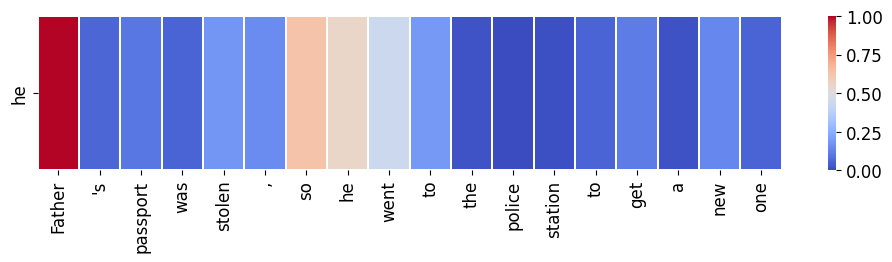

In [ ]:
sentence = "Father's passport was stolen, so he went to the police station to get a new one"
target_word = "he"
visualize_self_attention_in_context(sentence, target_word)

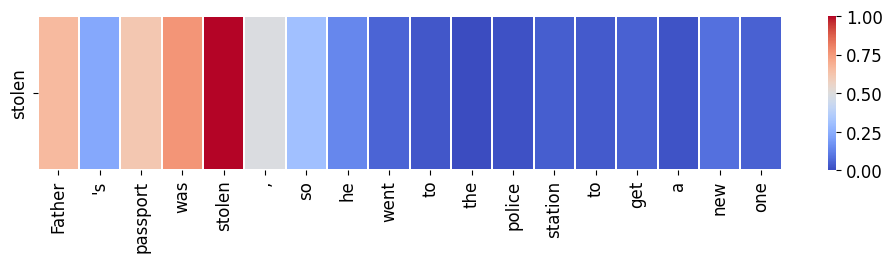

In [ ]:
sentence = "Father's passport was stolen, so he went to the police station to get a new one"
target_word = "stolen"
visualize_self_attention_in_context(sentence, target_word)

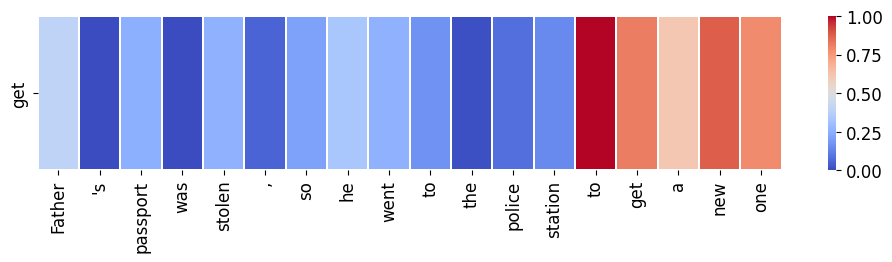

In [ ]:
sentence = "Father's passport was stolen, so he went to the police station to get a new one"
target_word = "get"
visualize_self_attention_in_context(sentence, target_word)

So, how does it work?

## Self-Attention

Self attention works by calculating the attention weight of each token in the input sequence to every other token in the input sequence. This means that the attention weight of each token will be calculated to every other token in the input sequence.

![Self Attention](https://peterbloem.nl/files/transformers/self-attention.svg)

Source: [Peterbloem](https://peterbloem.nl/blog/transformers)


$x_1$ is embedding vector of the first token in the input sequence.  $x_2$ is embedding vector of the second token in the input sequence. And soon

While $y_2$ is the attention weight of the second token in the input sequence.


In the above diagram, to get the value of $y_2$ we need to calculate:
$$w_{21} = x_2^T \cdot x_1$$
$$w_{22} = x_2^T \cdot x_2$$
$$w_{23} = x_2^T \cdot x_3$$
$$w_{24} = x_2^T \cdot x_4$$

Then sum them up:
$$y_2 = w_{21} + w_{22} + w_{23} + w_{24}$$


Let's take a look at $w_{21}$:

$w_{21}$ is the dot product of the embedding vector of the second token and the embedding vector of the first token. This is similar to our first naive approach

Then those score is multiplied by $x_1$. So the more closely related $x_1$ and $x_2$ are, the higher the affect of $x_1$ to $y_2$.

Then we do the same thing for $x_3$ and $x_4$.




### Weight Matrix

To make the model able to adapt to the context of a sentence, weight matrixes were introduced

So, the weight matrix make it possible for the model to learn different relation between tokens in different context.

e.g.

> I hate soccer because it is boring

The weight matrix allows the model to learn that "it" refers to "soccer" in this context.

To be able to do that, Transformer needs 3 weight matrixes, $W_Q$, $W_K$, and $W_V$. What are they?


### Key, Query, Value

> "The cat sat on the mat."

Imagine we're processing the word "sat" and trying to determine its context.

- Query (Q): This would be generated from the word "sat". The Query is like asking a question: "Which words in the sentence are most relevant to me (the word 'sat')?"

- Keys (K): These are generated for every word in the sentence. They serve as unique "labels" or "identifiers" for each word. In this context, the Keys for "The", "cat", "on", "the", and "mat" will each provide a means to match how relevant they are to the Query.

- Values (V): These are also generated for every word in the sentence. You can think of them as the actual "content" or "information" from each word. Once the model determines which words are most relevant to the Query using the Keys, it will fetch the corresponding Values to produce the output representation.

Those representation are represented by different weight matrixes: $W_Q$, $W_K$, and $W_V$.

Those weight matrixes are multiplied by the embedding vector of each token to get the query, key, and value of each token.

$$q = W_Q \cdot x$$
$$k = W_K \cdot x$$
$$v = W_V \cdot x$$

![KQV](https://peterbloem.nl/files/transformers/key-query-value.svg)

Source: [Peterbloem](https://peterbloem.nl/blog/transformers)

Please compare the above diagram with the previous one. The only difference is that now we have 3 weight matrixes, $W_Q$, $W_K$, and $W_V$.

## Multi Head

> Cat hates dog because it is scary

The weight matrix allows the model to learn that "it" refers to "dog" in this context.

... but what if we want to learn that "it" refers to "cat" in this context?

We can't do that with only one weight matrix. We need multiple weight matrixes.

This is where multi head attention comes in.

![Multi Head](https://peterbloem.nl/files/transformers/multi-head.svg)

Source: [Peterbloem](https://peterbloem.nl/blog/transformers)

In the multi head attention, we have multiple weight matrixes, $W_Q$, $W_K$, and $W_V$. Each of them is called a head. And each head will learn different relation between tokens.

To visualize multi head attention, please run this [Notebook](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing#scrollTo=T3H0qUZvPOP4)

![Multi Head Attention from its paper](https://storage.googleapis.com/rg-ai-bootcamp/nlp/image-29.png)

Source: [Attention is All you Need paper](https://arxiv.org/abs/1706.03762)

## Positional Encoding

![Transformer](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/The-Transformer-model-architecture.png/600px-The-Transformer-model-architecture.png)

The self attention layer doesn't take into account the position of each token in the input sequence. This is a problem because the position of each token in the input sequence is important. For example, in the sentence "I went to the store", the word "I" is the subject, while the word "store" is the object. If we change the position of the word "I" and "store", the meaning of the sentence will change.

To solve this problem, we need to add positional encoding to the input sequence. This is done by adding a positional encoding vector to the embedding vector of each token.

The formula is as follows:

$$PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})$$
$$PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})$$

Where $pos$ is the position of the token in the input sequence, $i$ is the dimension of the embedding vector, and $d_{model}$ is the dimension of the embedding vector.

It's a bit complicated, but the idea is that we want to make sure that the positional encoding vector is different for each position. We do this by using a sine and cosine function with different frequencies.

![Positional Encoding](https://storage.googleapis.com/rg-ai-bootcamp/nlp/image-28.png)

Source [Coding a Transformer from scratch on PyTorch, with full explanation, training and inference.](https://www.youtube.com/watch?v=ISNdQcPhsts&t=1467s)

## Decoder

Let's revisit the architecture:

![Transformer](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/The-Transformer-model-architecture.png/600px-The-Transformer-model-architecture.png)

The decoder is similar to the encoder, but with one difference: the decoder has an extra self attention layer that takes the output of the encoder as input: $W_K$ and $W_V$.

The idea is that, the learned $W_K$ and $W_V$ is passed to the decoder, so that the decoder can learn the relation between the input sequence and the output sequence.

## Linear Layer & Softmax

The final layer is a linear layer and a softmax layer. The linear layer is used to convert the output of the decoder to the same dimension as the vocabulary size. The softmax layer is used to convert the output of the linear layer to a probability distribution.

e.g.

> "I went to the __"

The output of the decoder will be a probability distribution of the next token in the output sequence. e.g. "store", "park", "school", etc.

$
\begin{bmatrix}
0.01 & 0.02 & 0.1 & 0.4 & 0.0 & ... & 0.12
\end{bmatrix}$